## Week 9: Practicalities

In the past weeks of the course you have had the opportunity to familiarize yourself with the nuts and bolts of Monte Carlo simulations and have tested your skills with the computer assignments in the jupyter notebooks. In doing so, especially for the computation intensive models of the last few weeks, you probably have contemplated whether the process could not be organized more efficiently: perhaps you were running the simulation in the notebook and had to wait for it to finish before continuing with the analysis; or you realized upon coming back to the exercises next day that you had to rerun the simulations because the data was lost; or the 3-hour limit on the jupyterhub sessions was getting in the way of producing a satisfactory amount of data; or the different pieces of code you have written (and rewritten, adapted, patched,...) are scattered in a non-linear fashion in the notebook cells; or.... If you have not encountered these limitations yet, you will certainly face them in the project you are about to commence. It is therefore a good idea that to discuss some organizational aspects of running a medium to large scale simulation project.

### Coding

#### An example

Let us go through an explicit example: simulating the 2D Ising model with the Wolff algorithm as we did in week 6. The first thing we should do is make a stand-alone program that can perform the required simulation. For this we can use the Python script `ising.py` available in the folder `ising_example`.

```Python
import numpy as np
from collections import deque
import argparse
import time
import json

rng = np.random.default_rng() 

# Required for easily parsing NumPy arrays into a JSON file (https://stackoverflow.com/a/49677241)
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# Ising model code from week 6
def aligned_init_config(width):
    '''Produce an all +1 configuration.'''
    return np.ones((width,width),dtype=int)

def neighboring_sites(s,w):
    '''Return the coordinates of the 4 sites adjacent to s on an w*w lattice.'''
    return [((s[0]+1)%w,s[1]),((s[0]-1)%w,s[1]),(s[0],(s[1]+1)%w),(s[0],(s[1]-1)%w)]

def cluster_flip(state,seed,p_add):
    '''Perform a single Wolff cluster move with specified seed on the state with parameter p_add.'''
    w = len(state)
    spin = state[seed]
    state[seed] = -spin  
    cluster_size = 1
    unvisited = deque([seed])   # use a deque to efficiently track the unvisited cluster sites
    while unvisited:   # while unvisited sites remain
        site = unvisited.pop()  # take one and remove from the unvisited list
        for nbr in neighboring_sites(site,w):
            if state[nbr] == spin and rng.uniform() < p_add: 
                state[nbr] = -spin
                unvisited.appendleft(nbr)
                cluster_size += 1
    return cluster_size

def wolff_cluster_move(state,p_add):
    '''Perform a single Wolff cluster move on the state with addition probability p_add.'''
    seed = tuple(rng.integers(0,len(state),2))
    return cluster_flip(state,seed,p_add)

def run_ising_wolff_mcmc(state,p_add,n):
    '''Run n Wolff moves on state and return total number of spins flipped.'''
    total = 0
    for _ in range(n):
        total += wolff_cluster_move(state,p_add)
    return total

def compute_magnetization(config):
    '''Compute the magnetization M(s) of the state config.'''
    return np.sum(config)

# use the argparse package to parse command line arguments
parser = argparse.ArgumentParser(description='Measures the magnetization in the 2D Ising model')
parser.add_argument('-w', type=int, help='Lattice size W')
parser.add_argument('-t', type=float, help='Temperature T (in units where J=kB=1)')
parser.add_argument('-n', type=int, help='Number N of measurements (indefinite by default)')
parser.add_argument('-e', type=int, default=100, help='Number E of equilibration sweeps')
parser.add_argument('-m', type=int, default=10, help='Number M of sweeps per measurement')
parser.add_argument('-o', type=int, default=30, help='Time in seconds between file outputs')
parser.add_argument('-f', help='Output filename')
args = parser.parse_args()

# perform sanity checks on the arguments
if args.w is None or args.w < 1:
    parser.error("Please specify a positive lattice size!")
if args.t is None or args.t <= 0.0:
    parser.error("Please specify a positive temperature!")
if args.e < 10:
    parser.error("Need at least 10 equilibration sweeps")

# fix parameters
temperature = args.t
p_add = 1 - np.exp(-2/temperature)
width = args.w
if args.f is None:
    # construct a filename from the parameters plus a timestamp (to avoid overwriting)
    output_filename = "data_w{}_t{}_{}.json".format(width,temperature,time.strftime("%Y%m%d%H%M%S"))
else:
    output_filename = args.f

# equilibration
state = aligned_init_config(width)
total_spin_flips = 0
total_moves = 0
equilibration_target = args.e * width * width
while total_spin_flips < equilibration_target:
    total_spin_flips += wolff_cluster_move(state,p_add)
    total_moves += 1
average_cluster_size = total_spin_flips / total_moves

# measurement phase
moves_per_measurement = int(args.m * width * width / average_cluster_size)
measurements = 0
start_time = time.time()
last_output_time = time.time()
magnetizations = []
while True:
    run_ising_wolff_mcmc(state,p_add,moves_per_measurement)
    magnetizations.append(compute_magnetization(state))
    measurements += 1

    if measurements == args.n or time.time() - last_output_time > args.o:    
        # output as json file
        with open(output_filename,'w') as outfile:
            json.dump({ 
                'parameters': vars(args),
                'average_cluster_size': average_cluster_size,
                'start_time': time.asctime(time.localtime(start_time)),
                'current_time': time.asctime(),
                'run_time_in_seconds': int(time.time() - start_time),
                'measurements': measurements,
                'moves_per_measurement': moves_per_measurement,
                'magnetizations': magnetizations
                }, outfile, cls=NumpyEncoder)
        if measurements == args.n:
            break
        else:
            last_output_time = time.time()

```

Let me highlight two features that are new compared to what we are used to in the Jupyter notebooks:
* It uses the [`argparse`](https://docs.python.org/3/library/argparse.html) package to read the simulation parameters from the command line. This has the great advantage that we can change all parameters without changing the source code. For instance, if we wish to run a simulation of the Ising model on a 20x20 grid at temperature $T=2.5$ and obtain $200$ samples we would run
```bash
$ python3 ising.py -w 20 -t 2.5 -n 200 -f data_example.json
```
and the output would be stored in the file `data_example.json`.
Note that there are several more optional command line parameters one can set (equilibration time, output file, ...) but they are assigned default values for convenience.
* The simulation results are stored in a JSON file, which is a versatile and universally readable file format. This is done at the very end of the simulation when the desired number of measurements has been performed, but also periodically every 30 seconds (but this you can set with the parameters). It has the advantage that you can monitor the progress of the simulation and kill the script at any time without loosing much data. Note that we do not just save the observables but also the command line parameters and various other quantities that may be of interest later. In general it is good practice to store all information necessary to reproduce the data.

Now suppose we have run our simulation with the command line above. We can then easily read the data in this notebook...

In [15]:
import json

with open('ising_example/data_example.json') as file:
    data = json.load(file)

print(data)

{'parameters': {'w': 20, 't': 2.5, 'n': 200, 'e': 100, 'm': 10, 'o': 30, 'f': 'data_example.json'}, 'average_cluster_size': 55.577777777777776, 'start_time': 'Mon Nov 15 08:51:28 2021', 'current_time': 'Mon Nov 15 08:51:30 2021', 'run_time_in_seconds': 2, 'measurements': 200, 'moves_per_measurement': 71, 'magnetizations': [128, 96, -252, 72, -222, 140, 218, -48, 92, 98, 126, 232, -218, -124, 8, 8, -276, -192, 238, 186, -176, 182, -54, -156, -122, -216, 166, -126, -104, 180, -14, -74, 130, -170, -138, -48, 176, 6, -132, 140, 42, -62, -154, 142, -108, -120, 200, -200, -174, 98, -170, 258, -90, -38, -8, -80, 160, -142, -280, 138, -130, -136, -176, -256, 116, 0, 200, 62, 150, -114, -146, 84, -156, 156, 194, -126, 248, -46, -184, 138, 4, -152, -112, 144, 126, 246, 90, -196, -34, -64, -10, -170, -28, 98, -102, 210, 160, -218, -84, 160, 90, -84, 38, 158, 102, -4, 120, 50, -72, -122, -166, 174, 264, -94, -132, 178, 174, -244, -114, 84, -190, -96, 160, 288, -62, 126, 158, 86, 8, -134, -206, -26

... and perform data analysis.

In [13]:
import numpy as np

def batch_estimate(data,observable,num_batches):
    batch_size = len(data)//num_batches
    values = [observable(data[i*batch_size:(i+1)*batch_size]) for i in range(num_batches)]
    return np.mean(values), np.std(values)/np.sqrt(num_batches-1)

abs_magnetizations = np.abs(np.array(data['magnetizations']))
print("Magnetization: E[|m|] = {} +- {}".format(*batch_estimate(abs_magnetizations,np.mean,10)))

Magnetization: E[|m|] = 139.44 +- 4.563215240741261


### Data gathering

Once you are confident that your simulation code works as intended and you have a good idea of the parameter ranges you would like to collect data for, you are at a stage to scale up and invest some serious cpu time. Of course you could occupy all cores on your pc or laptop and take a nap, but there is a more practical alternative: the compute cluster of our faculty. Those that have signed up for this course, will have been granted access to the High Energy Physics cluster nodes (node = single machine). Running jobs on the cluster nodes requires some preparations, since they are to be submitted through the [SLURM job scheduling system](https://wiki.cncz.science.ru.nl/Slurm). Don't worry, this is not complicated!

#### Logging in to one of the compute nodes

First you will have to login with `ssh` into one of the compute nodes using a terminal. There are several ways to do this. 
* The first option is to use the terminal interface of JupyterHub in the browser. Simply head to the file system page and select `New` (top-right corner) and `Terminal`. This will bring up a browser tab with a direct ssh interface with to compute node on which your jupyter session is running.
* If you are on a faculty-managed linux machine, you can simply open the built-in Terminal (`Ctrl + Alt + T`).
* From your own computer you can use the built-in Terminal on linux or MacOS, or PuTTy on Windows, but you first have to login into one of the faculties login-servers, e.g. 
```bash
$ ssh yourusername@lilo7.science.ru.nl
```
which will prompt for your science password.

Then login into one of the cluster nodes (cn26, cn44, cn29, cn96, cn97, cn98) by running e.g. 
```bash 
$ ssh cn44
``` 
If your access is denied, please contact me because you may not be added to the right unix groups yet. The command `sinfo` will provide information on the SLURM partitions to which you have been granted access. It will look something like this:
```bash 
$ sinfo
PARTITION  AVAIL  TIMELIMIT  NODES  STATE NODELIST
hefstud       up   infinite      2    mix cn[96,98]
hefstud       up   infinite      4  alloc cn[26,29,44,97]
cnczshort     up   12:00:00      1   idle cn13
cncz          up 7-00:00:00      1   idle cn13
jupyter       up    4:00:00      6   idle cn[60-64,66]
``` 
The relevant partition is `hefstud` (for High Energy Physics students). As you see it lists the 6 cluster nodes with an indication of the status (in this example cn26, cn29, cn44 and cn97 are fully occupied and cn96, cn98 are partially, so it is pretty busy). The currently running and queued jobs can be displayed with `squeue`. Note: `hefstud` is not the only partition using these machines, so the machines may be occupied even if `squeue` does not show any running jobs. 

#### Submitting a job script

Now we wish to perform our simulation on the cluster node. You could execute it in the terminal by running `python3 ising.py ...`, but please do not do this (unless to quickly test if the code will run on this machine)! The proper way is to submit your job as a SLURM task. For this you should prepare a simple bash script. Let us assume the script `ising.py` is located in the folder `monte-carlo-techniques-2021/lectures/ising_example` in your science home directory. A minimal version of the bash script would look like this and we would save it in a file `ising_job.sh`.
```bash
#!/bin/bash
#SBATCH --partition=hefstud
#SBATCH --output=std_%A_%a.txt
#SBATCH --mem=100M
#SBATCH --time=2:00:00
cd ~/monte-carlo-techniques-2021/lectures/ising_example
/software/anaconda3/bin/python3 ising.py -w 20 -t 2.5 -n 100
```
The lines with `#SBATCH` tell SLURM what resources are requested and how to administrate the job. 
* In particular, we are telling SLURM that the job should run on the `hefstud` partition (so on one of its 6 nodes). 
* Any output generated by your script together with the job details will be stored in a file whose name depends on the job id (but you could specify a filename yourself if you wish). 
* The `--mem=1000M` tells that you won't be using more than 1000MB of memory.
* The `--time=2:00:00` option specifies the maximal run time of your script before it will be killed (in this case 2 hours). You can specify a maximal run time of, say, 3 days using the format `--time=3-0:00:00`.

The lines that do not start with # are commands that will be executed, in this case the working directory is set to your home directory and then the python script is executed. **Important**: use python3 provided by the anaconda3 software instead of the ubuntu-provided python3! The former is the one used by JupyterHub and is up to date, while the latter may use outdated packages (in particular the NumPy package is too old!).

To submit the job simply run the following command in the terminal.
```bash
$ sbatch ising_job.sh
```
If the job does not finish (almost) instantaneously you will see it in the job queue.
```bash
$ squeue -u yourusername
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3785215   hefstud isingjob username  R       0:10      1 cn96
```
This means that the schedules has found a node (cn96) with sufficient resources to execute your job, but it can also happen that the job remains queued until resources are available. The job will disappear as soon as your script has finished. If necessary you can kill the job before it is completed by calling `scancel` with the job id as parameter.
```bash
$ scancel 3785215
```

#### Running multiple jobs

Most often you will want to run many jobs with the same script, but each with different parameters. For this you could produce many bash scripts (possibly in an automated fashion), but there are other options as well. If you wish to run the scripts sequentially, you can simply use a for loop in the bash script. For instance, the following will execute the script for temperatures 1.5, 1.6, ..., 3.5 one after the other. 
```bash
#!/bin/bash
#SBATCH --partition=hefstud
#SBATCH --output=std_%A_%a.txt
#SBATCH --mem=100M
#SBATCH --time=2:00:00
cd ~/monte-carlo-techniques-2021/lectures/ising_example
for temp in $(LANG=en_US seq 1.5 0.1 3.5)
do
	/software/anaconda3/bin/python3 ising.py -w 10 -t ${temp} -n 20
done
```
If you want to run several of these jobs simultaneously, you could use a **job array**. This is done by including an instruction like `#SBATCH --array=0-20%3` which tells SLURM to turn the job submissions into 21 individual jobs (with index 0,1,...,20), but never to run more than 3 at the same time. The index of the job is accessible as `$SLURM_ARRAY_TASK_ID` and can be used to determine the parameters for each individual job.
```bash
#!/bin/bash
#SBATCH --partition=hefstud
#SBATCH --output=std_%A_%a.txt
#SBATCH --mem=100M
#SBATCH --time=2:00:00
#SBATCH --array=0-20%3
cd ~/monte-carlo-techniques-2021/lectures/ising_example
temperatures=($(LANG=en_US seq 1.5 0.1 3.5))
temp=${temperatures[$SLURM_ARRAY_TASK_ID]}
/software/anaconda3/bin/python3 ising.py -w 20 -t ${temp} -n 500
```

We can then read all data files and perform analysis in this notebook:

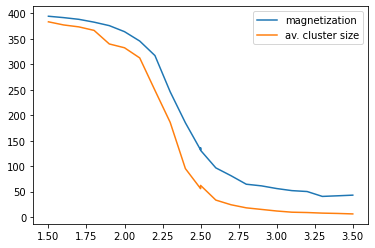

In [16]:
import matplotlib.pylab as plt
%matplotlib inline

import os

def read_all_json(directory,startswith):
    data = []
    for filename in sorted(os.listdir(directory)):
        if filename.startswith(startswith) and filename.endswith(".json"):
            with open(os.path.join(directory,filename)) as file:
                data.append(json.load(file))
    return data

data = read_all_json("ising_example","data_w20_")
plt.plot([d['parameters']['t'] for d in data],[np.mean(np.abs(d['magnetizations'])) for d in data])
plt.plot([d['parameters']['t'] for d in data],[d['average_cluster_size'] for d in data])
plt.legend(["magnetization","av. cluster size"])
plt.show()

### Remarks

* **Be considerate to other users.** The department's compute nodes are shared between research staff and interns and students from this course. CPU resources and memory are limited. Feel free to occupy 1~3 cores full time. Or use  more cores for short periods (hours) when the server load is low, but try at all times to leave resources available to others. Be prepared to kill your jobs, if requested by my colleagues or me.
* **Have your scripts write partial results to disk periodically.** This way the job becomes as cancelable as possible and you have the opportunity to inspect progress. You want to prevent the situation that you have submitted a script that samples a million configurations for a dozen different model parameters and that only writes the results to a file at the very end. Perhaps the job takes more time than you anticipated: if an expected 12-hour job is not finished after two days and you don't know its progress, do you wait another day or kill the job? If for whatever reason you have to kill your script before it has finished, you could end up with no data at all. It is therefore advisable to store partial results periodically throughout the simulation.
* **Only write files in your home directory.** The cluster nodes have local storage (scratch), but for the purposes of your project you will probably not need it. Given that scratch is not backed up and its contents differs from one node to the other, I would advise you to stick to your own home directory.